By:
Milica Vukašinović and Antoine Dávid
Github: 
uwjht

we kindly request a new github invitation link. I (Antoine) inconviniently overstepped the invitation deadline of 7 days. won't happen again

# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [ ]:
# Connect Google Colab to Google Drive
from google.colab import drive
import os
import zipfile

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

val_path = '/content/drive/My Drive/val' # <--- **UPDATE THIS PATH**
train_path = '/content/drive/My Drive/train' # <--- **UPDATE THIS PATH**
test_path = '/content/drive/My Drive/test_public' # <--- **UPDATE THIS PATH**
#with zipfile.ZipFile(val_path+'.zip', 'r') as zip_ref:
#    zip_ref.extractall("/content/drive/My Drive")
#with zipfile.ZipFile(train_path+'.zip', 'r') as zip_ref:
#    zip_ref.extractall("/content/drive/My Drive")
#with zipfile.ZipFile(test_path+'.zip', 'r') as zip_ref:
#    zip_ref.extractall("/content/drive/My Drive")


## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [ ]:
import torch
import pickle
import numpy as np
from torch.utils.data import Dataset
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
import torchvision.transforms as T


class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False, augment=False):
        self.samples = file_list
        self.test = test
        self.augment = augment
        # self.transform is used to augment the visual data as stored in the camera
        # it utilizes Jitter, a random flip and cropping.
        self.transform = T.Compose([
            T.ToPILImage(),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            T.RandomHorizontalFlip(),
            T.RandomResizedCrop((200, 300), scale=(0.9, 1.0)),
            T.ToTensor()
        ]) if augment else None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # get data
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)
        
        # get camera, history, depth, future, semantic (driving command was not significant in trials)
        camera = data['camera']
        camera = camera.astype(np.uint8)
        if self.augment:
            camera = self.transform(camera)
        # normalize camera
        camera = torch.FloatTensor(camera).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])
        depth = torch.FloatTensor(data['depth'])
        semantic = torch.FloatTensor(data['semantic_label'])

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'future': future,
                'semantic': semantic
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic
            }

## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

In [ ]:
'''
while efficientnetb0 worked well in the first submission we now return to resnet34 
as it is sufficient and significantly faster to train.

We also add a spatial attention block to the CNN backbone. the spatial attention
block is a simple multi-head attention mechanism.

We use simple MLPs to process the history, depth and semantic inputs. suprisingly
implementing CNNs here did not significantly improve the results.
Adding dropout layers as commonly used in MLPs appeared to introduce noise
and hurt the performance.

The next step might be a transformer based architecture.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34

class SpatialAttentionBlock(nn.Module):
    # self attention block for features extracted from camera data
    def __init__(self, embed_dim=512, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: (B, C, H, W) -> (B, H*W, C)
        B, C, H, W = x.shape
        x_flat = x.view(B, C, H * W).permute(0, 2, 1)  # (B, H*W, C)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        attn_out = self.norm(attn_out + x_flat)
        # Back to (B, C, H, W)
        attn_out = attn_out.permute(0, 2, 1).view(B, C, H, W)
        return attn_out

class AdvancedDrivingPlanner(nn.Module):
    # main model class
    # it predicts future trajectory, depth, semantic segmentation
    def __init__(self,
                 history_dim=(21, 3),
                 future_steps=60):
        super().__init__()
        self.log_var_traj = nn.Parameter(torch.zeros(1))

        # CNN Backbone (ResNet34)
        resnet = resnet34(weights="IMAGENET1K_V1")
        self.cnn_backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        self.cnn_out_dim = 512
        self.cnn_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.attention = SpatialAttentionBlock(embed_dim=self.cnn_out_dim)

        # MLP for processing history input
        self.history_mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(history_dim[0] * history_dim[1], 128),
            nn.ReLU()
        )

        # Fusion and trajectory decoder
        fusion_dim = self.cnn_out_dim + 128  # CNN + history
        self.fusion_mlp = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.traj_decoder = nn.Linear(128, future_steps * 3)

    def _init_depth_decoder(self):
        # Decoder for depth prediction (uses CNN feature extraction)
        self.depth_decoder = nn.Sequential(
            nn.ConvTranspose2d(self.cnn_out_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)
        )

    def _init_semantic_decoder(self):
        # Decoder for semantic segmentation (uses CNN feature extraction)
        self.semantic_decoder = nn.Sequential(
            nn.ConvTranspose2d(self.cnn_out_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 15, kernel_size=3, padding=1),  # 15 semantic classes
            nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)
        )

    def forward(self, camera, history):
        B = camera.size(0)

        # Extract visual features
        cnn_feat = self.cnn_backbone(camera)  # (B, 512, H', W')
        cnn_feat = self.attention(cnn_feat)
        pooled_feat = self.cnn_pool(cnn_feat).view(B, -1)  # (B, 512)

        # History encoding
        hist_feat = self.history_mlp(history)
        features = [pooled_feat, hist_feat]

        # Fuse and predict future trajectory
        fused = torch.cat(features, dim=1)
        fused = self.fusion_mlp(fused)
        future = self.traj_decoder(fused).view(B, -1, 3)
        return future

## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [ ]:
import torch
import torch.nn.functional as F

def train_one_epoch(model, train_loader, optimizer, device):
    # runs one epoch
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cam = batch['camera'].to(device)
        hist = batch['history'].to(device)
        fut = batch['future'].to(device)
        optimizer.zero_grad()
        fut_pred, dep_pred, sem_pred = model(cam, hist)

        # Uncertainty-weighted losses
        traj_loss = F.mse_loss(fut_pred[...,:2], fut[...,:2], reduction='none')
        loss = torch.exp(-model.log_var_traj) * traj_loss + model.log_var_traj
        # Backpropagation
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device):
    # model evaluation on ADE, FDE, MSE
    model.eval()
    total_ade, total_fde, total_mse = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            cam = batch['camera'].to(device)
            hist = batch['history'].to(device)
            fut = batch['future'].to(device)
            fut_pred = model(cam, hist)
            B, T, _ = fut.shape
            count += B

            ade = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean(dim=1).sum()
            fde = torch.norm(fut_pred[:, -1, :2] - fut[:, -1, :2], dim=1).sum()
            mse = F.mse_loss(fut_pred, fut, reduction='sum')

            total_ade += ade.item()
            total_fde += fde.item()
            total_mse += mse.item()

    ade_avg = total_ade / count
    fde_avg = total_fde / count
    mse_avg = total_mse / (count * T * 3)
    return ade_avg, fde_avg, mse_avg

def train(model, train_loader, val_loader, optimizer,scheduler, num_epochs=70, use_depth_aux=False, use_semantic_aux=False):
    # main training loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    best_ade = float('inf')

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, use_depth_aux, use_semantic_aux)
        ade, fde, mse = validate(model, val_loader, device, use_depth_aux, use_semantic_aux)

        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Validation - ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")
        scheduler.step()
        # save the best model (distinguished by ADE score)
        if epoch == 0 or ade < best_ade:
            best_ade = ade
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Model saved at epoch {epoch+1} with ADE: {best_ade:.4f}")


In [ ]:
# this cell loads the data into the format used for training
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files, augment=True)  # Enable augmentation for training
val_dataset = DrivingDataset(val_files, augment=False)     # No augmentation for validation

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2, pin_memory=True)

## 🔍 Let's Compare Two Settings

We'll now train and evaluate the model in **two modes**:

1. **Without auxiliary task** — the model only predicts the trajectory.
2. **With depth auxiliary task** — the model also predicts a depth map, which helps it learn better visual features.

By comparing the results (ADE, FDE, and Trajectory MSE), you'll see the benefit of multi-task learning in action! 🚀

In [ ]:
'''
for the best performance we experimented with the:
-learning rate (from 1e-4 to 5e-3) best with lr of 2e-3)
-batch size (16, 32, 64) good for 32 (trade-off between stability and speed)
-scheduler step size and gamma affected stability or speed of convergence. 
step size of 50 and gamma of 0.05 showed good convergence
'''
# use depth and semantic as auxiliary inputs! -> True, True
use_depth_aux=True
use_semantic_aux=True
# load  model, opti.., schedu.. and let's train
model = AdvancedDrivingPlanner(use_depth_aux=use_depth_aux, use_semantic_aux=use_semantic_aux)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.05)
train(model, train_loader, val_loader, optimizer,scheduler,num_epochs=100, use_depth_aux=use_depth_aux, use_semantic_aux=use_semantic_aux)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 128MB/s]


Using device: cuda
Epoch 1, Loss: 164.0571, Validation - ADE: 4.0060, FDE: 9.5291, Traj MSE: 12.464599
Model saved at epoch 1 with ADE: 4.0060
Epoch 2, Loss: 18.8992, Validation - ADE: 3.8645, FDE: 9.1912, Traj MSE: 12.038932
Model saved at epoch 2 with ADE: 3.8645
Epoch 3, Loss: 16.3429, Validation - ADE: 3.7556, FDE: 9.0979, Traj MSE: 11.155525
Model saved at epoch 3 with ADE: 3.7556
Epoch 4, Loss: 14.1415, Validation - ADE: 3.9214, FDE: 9.2535, Traj MSE: 11.557653
Epoch 5, Loss: 12.4617, Validation - ADE: 2.6378, FDE: 7.1253, Traj MSE: 7.288606
Model saved at epoch 5 with ADE: 2.6378
Epoch 6, Loss: 10.1639, Validation - ADE: 2.6261, FDE: 6.9456, Traj MSE: 7.191867
Model saved at epoch 6 with ADE: 2.6261
Epoch 7, Loss: 9.8324, Validation - ADE: 2.4363, FDE: 6.6508, Traj MSE: 6.428749
Model saved at epoch 7 with ADE: 2.4363
Epoch 8, Loss: 9.0780, Validation - ADE: 2.4818, FDE: 6.7807, Traj MSE: 6.137039
Epoch 9, Loss: 8.5264, Validation - ADE: 2.3876, FDE: 6.5120, Traj MSE: 5.835524
M

In [ ]:
# final evaluation of the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedDrivingPlanner(use_depth_aux=True, use_semantic_aux=True)
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
ade, fde, mse = validate(model, val_loader, device)
print(f"Validation results for model without depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

Validation results for model without depth auxiliary loss: ADE: 1.7429, FDE: 4.9129, Traj MSE: 3.462726


## 🔍 Final Visualization and Comparison

Now that we’ve trained two models — one **with** the depth auxiliary task and one **without** — let’s visualize and compare their predictions.

We’ll show:
1. The **camera image** from selected validation examples
2. The **past trajectory**, **ground-truth future**, and **predicted future** trajectory
3. The **predicted vs. ground-truth depth maps** (only for the model trained with the auxiliary task)

These visualizations help us understand:
- Does the predicted trajectory better match the future when the depth task is included?
- Is the predicted depth map reasonably accurate?

Let’s see the difference! 📈

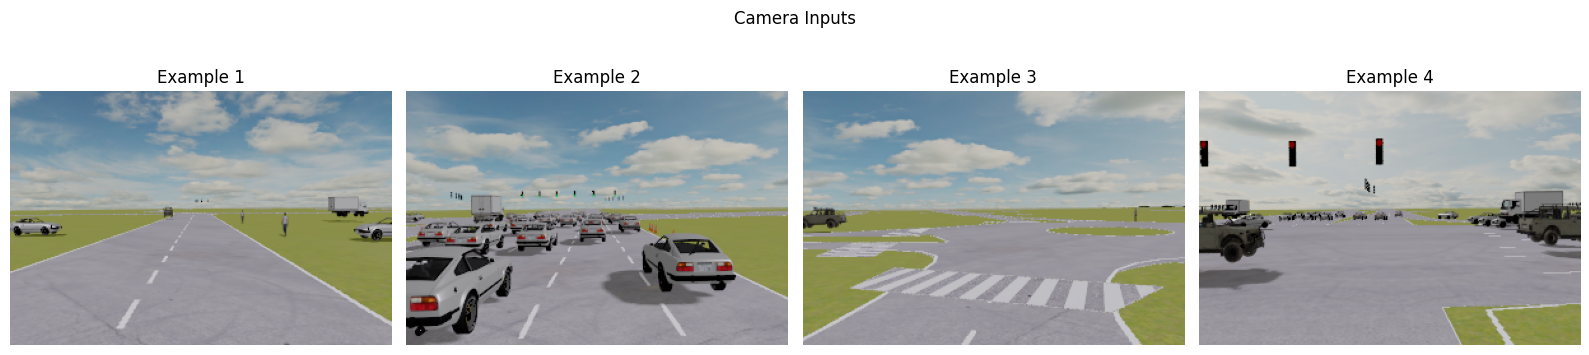

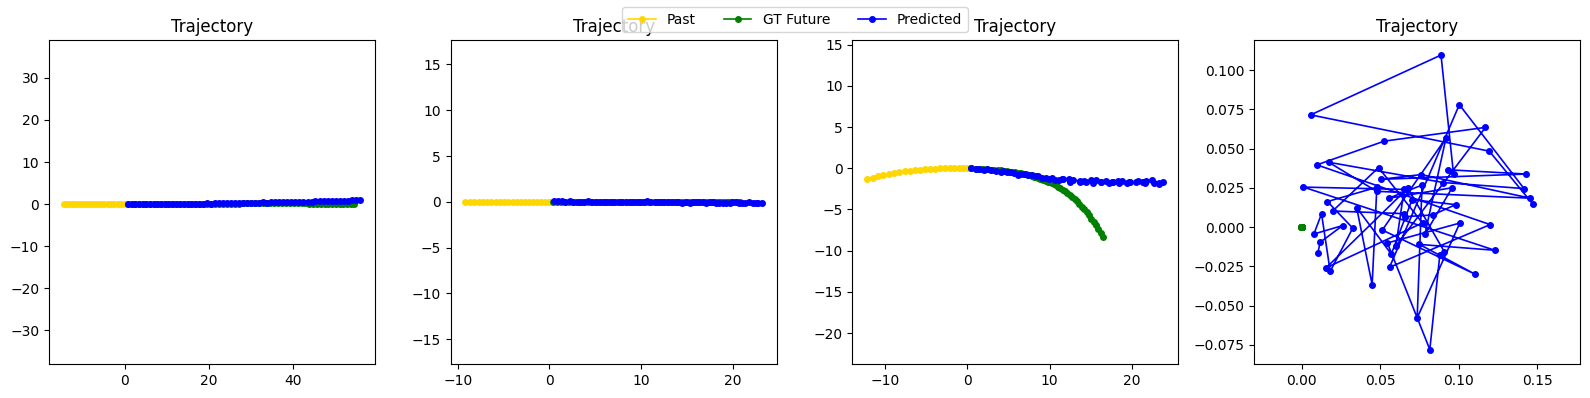

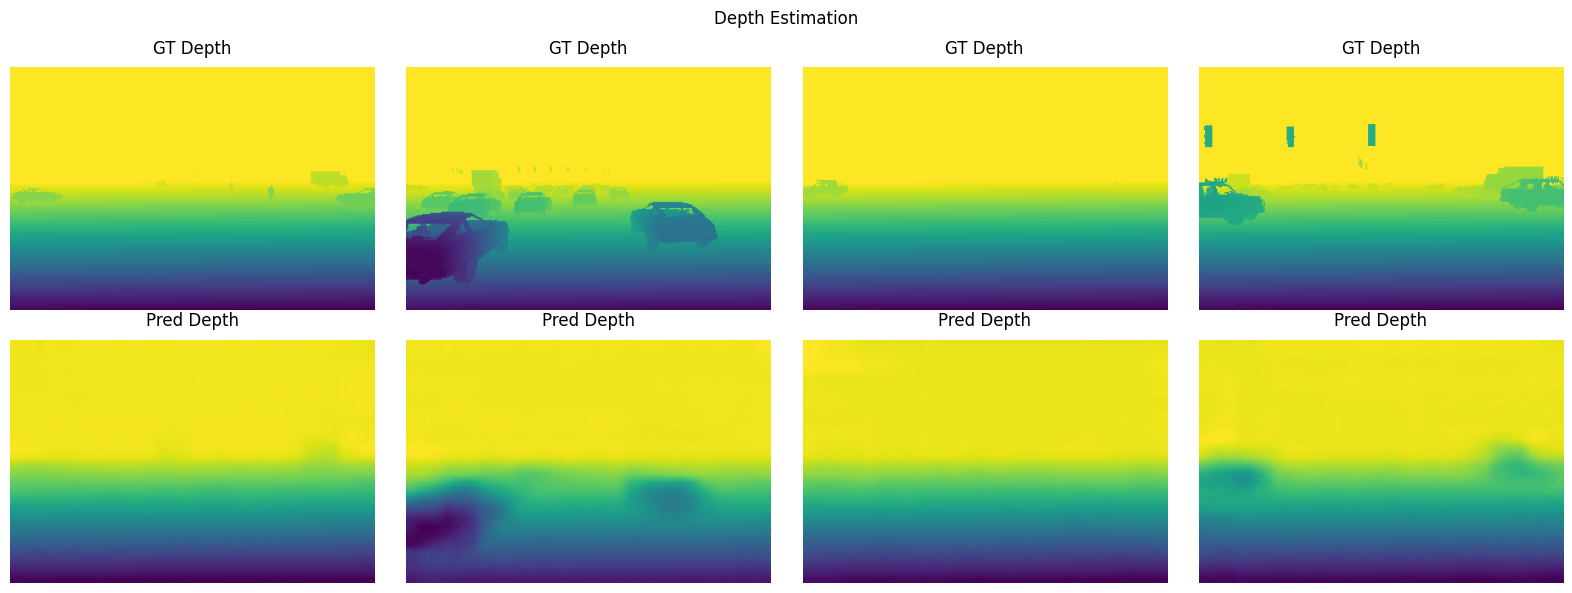

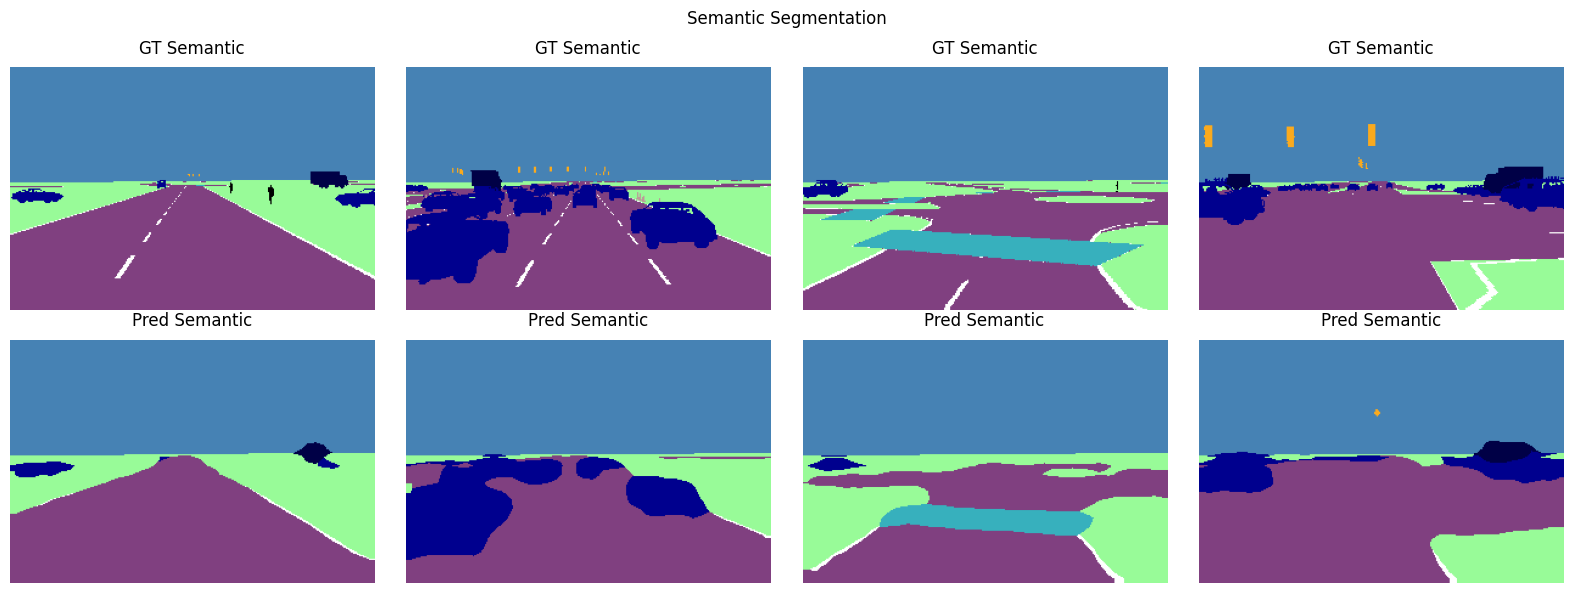

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

random.seed(40)

# Helper: map semantic mask to RGB using your colormap
def semantic_to_rgb(semantic_mask, colormap):
    # semantic_mask: (H, W), int
    h, w = semantic_mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in colormap.items():
        rgb[semantic_mask == class_idx] = color
    return rgb

semantic_colormap = {
    0: (0, 0, 0),         # UNLABELED
    1: (0, 0, 142),       # CAR
    2: (0, 0, 70),        # TRUCK
    3: (220, 20, 60),     # PEDESTRIAN
    4: (119, 11, 32),     # BIKE
    5: (152, 251, 152),   # TERRAIN
    6: (128, 64, 128),    # ROAD
    7: (244, 35, 232),    # SIDEWALK
    8: (70, 130, 180),    # SKY
    9: (250, 170, 30),    # TRAFFIC_LIGHT
    10: (190, 153, 153),  # FENCE
    11: (220, 220, 0),    # TRAFFIC_SIGN
    12: (255, 255, 255),  # LANE_LINE
    13: (55, 176, 189),   # CROSSWALK
    14: (0, 60, 100)      # BUS
}

def visualize_single_model(val_loader, model, device):
    model.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)
    semantic = val_batch['semantic'].to(device) if 'semantic' in val_batch else None

    with torch.no_grad():
        fut_pred, depth_pred, semantic_pred = model(camera, history, depth, semantic)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    fut_pred = fut_pred.cpu().numpy()
    depth = depth.cpu().numpy()
    depth_pred = depth_pred.cpu().numpy() if depth_pred is not None else None
    semantic = semantic.cpu().numpy() if semantic is not None else None
    semantic_pred = semantic_pred.cpu().numpy() if semantic_pred is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(fut_pred[idx, :, 0], fut_pred[idx, :, 1], 'o-', label='Predicted', color='blue', markersize=4, linewidth=1.2)
        ax[i].set_title("Trajectory")
        ax[i].axis("equal")
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3)
    plt.tight_layout()
    plt.show()

    # Show predicted vs GT depth (if available)
    if depth_pred is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            ax[1, i].imshow(depth_pred[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")
        plt.suptitle("Depth Estimation")
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

    # Show predicted vs GT semantic segmentation (if available)
    if semantic_pred is not None and semantic is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            # GT semantic: (H, W, 1) or (H, W)
            gt_sem = semantic[idx]
            if gt_sem.ndim == 3:
                gt_sem = gt_sem.squeeze(-1)
            gt_rgb = semantic_to_rgb(gt_sem.astype(np.int32), semantic_colormap)
            ax[0, i].imshow(gt_rgb)
            ax[0, i].set_title("GT Semantic", pad=10)
            ax[0, i].axis("off")
            # Predicted semantic: (H, W, C)
            pred_sem = np.argmax(semantic_pred[idx], axis=-1)
            pred_rgb = semantic_to_rgb(pred_sem.astype(np.int32), semantic_colormap)
            ax[1, i].imshow(pred_rgb)
            ax[1, i].set_title("Pred Semantic", pad=10)
            ax[1, i].axis("off")
        plt.suptitle("Semantic Segmentation")
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

visualize_single_model(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [10]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [ ]:
import pandas as pd
import numpy as np
import torch

# load the data via the data-class
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)

# model should be loaded beforehand. setting it to eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        depth = batch['depth'].to(device) if 'depth' in batch else None
        semantic = batch['semantic'].to(device) if 'semantic' in batch else None

        # Model returns: future, depth_out, semantic_out
        pred_future, _, _ = model(camera, history, depth, semantic)
        all_plans.append(pred_future.cpu().numpy()[..., :2])

all_plans = np.concatenate(all_plans, axis=0)  # (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = all_plans.shape
pred_xy_flat = all_plans.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
